In [1]:
import pandas as pd
import numpy as np
import os

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Methods
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# Statistical Tests
import scipy.stats as stats


# Custom Imports
import wrangle_zillow
from env import get_db_url

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Clustering Project: Zillow Zestimates Prediction

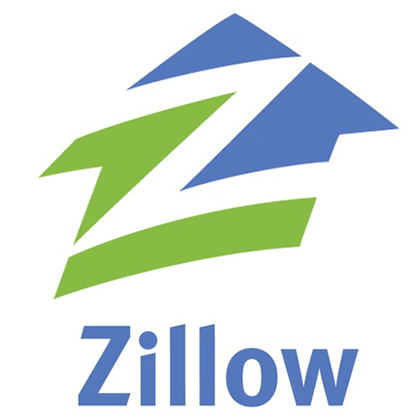

## Project Description:

The goal of this project is to identify drivers of error looking at logerror. The reason we want to be able to predict logerror to to better improve our current models. Improving our models helps better serve our customers at Zillow because we can give them the data they request without error. We want our customers to trust us and the best way to get them to do that is to be able to give them info that is accurate.

## Project Goals:

- Use clustering algorithms to help determine predictors of logerror to help improve the performance of our current model.
- Using drivers of logerror to help imrpove our model of property values.
- Improve understanding of logerror to better inform the use of models for property prediction.

## Executive Summary:


# Wrangle The Data

## Step 1: Acquire the data

#### Data was acquired from Zillow database in MySQL Workbench.

In [2]:
# Acquire function
df = wrangle_zillow.get_zillow()

In this step, I used SQL queries to pull what I wanted from Zillows tables.

## Step 2: Prepare Data

In this step, I created multiple functions that were meant to help me prepare my data for both exploration and modeling.

<b><font color = 'green'> handle_missing_values:</b></font> How to handle missing values based on minimum percentage of values for rows and columns

<b><font color = 'green'> wrangle_zillow:</b></font> The wrangle function has the acquire and handle_missing_values nested in it. This function is to explore on independent variables, which will help us decide what to use for clustering later.

Steps implemented: 

    - Get rid of null values in my columns (lose a lot of bulk, nearly no data loss) and redundant columns.
    - For the 'fips' column I both encode the zip codes to the appropriate countys (Los Angeles, Ventura, Orange County) and rename the column to 'County' for readability.
    - Removed outliers to many columns:
       - Bathroom and bedroom count range to 1 - 5
       - Logerror range to 0.5 to -0.31
       - Year built houses older than 1910
       - calculatefinishedsquarefeet range to 650 - 5500
       - taxvalluedollarcnt range to 40000 - 300000
<b><font color = 'green'> split:</b></font> This function splits the data into the 3 sets needed for exploring and statistical tests. I stratify on 'county' in this step.

<b><font color = 'green'>scale_data:</b></font> This function scales the the 3 split data sets. 

<b><font color = 'green'>wrangle_split_scale:</b></font>  This function combines everything in to one. We will do our clustering, testing, and modeling here.

# Explore

## The Big Questions: Can clustering help us predict logerror? Can clustering help us beat the baseline?

Our target variable is logerror, so we will be comparing it to individual features as well as combinations of features (clusters). 

For this Zillow project, since we would be using clustering, I wanted to focus on the major key features we have to work with and cluster features that are similar. I came up with three major themes:
1. Land - refers to the house itself. The size, year it was built, how many rooms, etc.
2. Location - refers to the geological location of the home.
3. Tax - refers to the taxes paid on the home. 


## Initial Hypothesis :
- 
-
-
-
-








First, lets bring in our functions so we can split the data and use the scaled and unscaled versions for exploration. We will want to use unscaled if we decide to look at independent variables, and once we start to cluster, we will want to use our unscaled versions.

In [3]:
# Wrangle and split into unscaled
df = wrangle_zillow.wrangle_zillow()
train, validate, test = wrangle_zillow.split(df)

In [4]:
# This is our scaled version for clustering and hypothesis testing
train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_split_scale()

Now, lets do a few independent variable testing, just to make sure that our assumptions are correct in reference to our clustering.

### Hypothesis Testing: Question One

#### Is there a relationship between yearbuilt and logerror?

H_0: There is no difference of variance or mean between county and logerror.

H_a: There is a difference of variance or mean between county and logerror.

Is there a relationship
between yearbuilt and logerror?


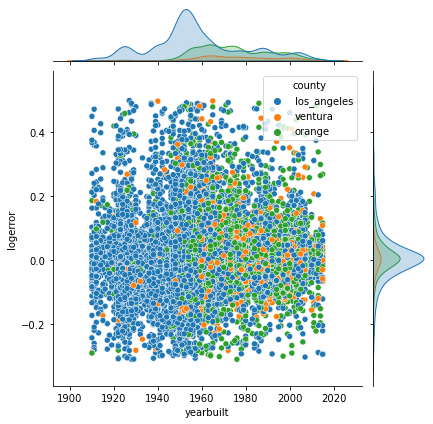

In [5]:
#creating a joinplot to see if any linear relationship (also adding in county)

print("Is there a relationship\nbetween yearbuilt and logerror?")
sns.jointplot(x="yearbuilt", y="logerror", data=train, hue = 'county')
plt.xlabel("Year built")
plt.ylabel("Logerror")
plt.show()

In [6]:
#setting alpha to standard 
alpha = 0.05

cor, p = stats.spearmanr(train.yearbuilt, train.logerror)
if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')


P is less than alpha. We reject the null hypothesis.


#### Therefore, I reject the null hypothesis and there does seem to be a relationship between yearbuilt and logerror.

Now we want to get into clusters. As I stated, I wanted to focus on themes, so I decided to go with land, location, and tax for my clusters. After trying elbow methods, the k value was best as 3 for all 3 clusters. 

(array([  213.,   494.,  1825., 12824.,  8974.,  1456.,   619.,   299.,
          152.,    97.]),
 array([-0.30939868, -0.2286935 , -0.14798832, -0.06728314,  0.01342204,
         0.09412722,  0.1748324 ,  0.25553758,  0.33624276,  0.41694794,
         0.49765312]),
 <BarContainer object of 10 artists>)

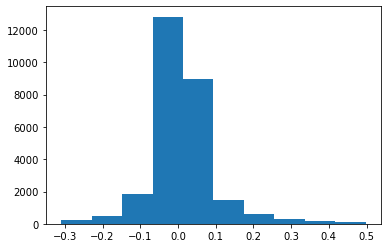

In [7]:
#checking the shape of logerror:
plt.hist(train_scaled.logerror)

### Cluster on Land Columns (bedroomcnt, bathroomcnt, roomcnt, yearbuilt)

In [8]:
# Creating and naming
landcluster = train_scaled[['bedroomcnt', 'bathroomcnt','roomcnt','yearbuilt']]
# Make object
kmeans = KMeans(n_clusters=3)
kmeans.fit(landcluster)
# Use the thing
kmeans.predict(landcluster)
#storing this predicted cluster of data into original dataframe
train_scaled['landcluster'] = kmeans.predict(landcluster)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

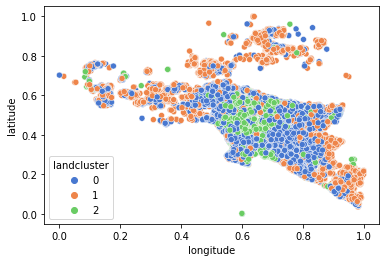

In [9]:
# Lets plot our  land cluster
sns.scatterplot(data=train_scaled, x='longitude', y='latitude', hue='landcluster', palette = sns.color_palette("muted", n_colors = 3))

## Question: Does the landcluster I created relate to logerror?

For my hypothesis testing, I will be using ANOVA tests.

## Hypothesis Testing

H_0: There is no difference of mean between logerror and landcluster.

H_a: There is a difference of mean between logerror and landcluster.



In [10]:
alpha = 0.05

F, p = stats.f_oneway(train_scaled[train_scaled.landcluster == 0].logerror,
                      train[train_scaled.landcluster == 1].logerror,
                      train[train_scaled.landcluster == 2].logerror,
                      train[train_scaled.landcluster == 3].logerror)

if p < alpha:
    print('We reject the null hypothesis\n')
else:
    print('We fail to reject the null hypothesis\n')

print('Anova Test Results on Cluster_Features')
print('F-value:',F)
print('P-value:',p)

We fail to reject the null hypothesis

Anova Test Results on Cluster_Features
F-value: nan
P-value: nan


### Cluster on Location Columns (latitude, longitude)

In [11]:
# Creating and naming
locationcluster = train_scaled[['latitude', 'longitude']]
# Make object
kmeans = KMeans(n_clusters=3)
kmeans.fit(locationcluster)
# Use the thing
kmeans.predict(locationcluster)
#storing this predicted cluster of data into original dataframe
train_scaled['locationcluster'] = kmeans.predict(locationcluster)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

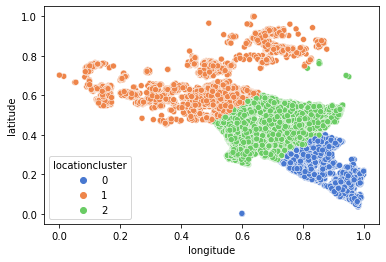

In [12]:
#plotting locationcluster
sns.scatterplot(data=train_scaled, x='longitude', y='latitude', hue='locationcluster', palette = sns.color_palette("muted", n_colors = 3))

## Question: Does the locationcluster I created relate to logerror?

## Hypothesis Testing

H_0: There is no difference of mean between logerror and locationcluster.

H_a: There is a difference of mean between logerror and locationcluster.


In [13]:
alpha = 0.05

F, p = stats.f_oneway(train_scaled[train_scaled.locationcluster == 0].logerror,
                      train[train_scaled.locationcluster == 1].logerror,
                      train[train_scaled.locationcluster == 2].logerror,
                      train[train_scaled.locationcluster == 3].logerror)

if p < alpha:
    print('We reject the null hypothesis\n')
else:
    print('We fail to reject the null hypothesis\n')

print('Anova Test Results on Cluster_Features')
print('F-value:',F)
print('P-value:',p)

We fail to reject the null hypothesis

Anova Test Results on Cluster_Features
F-value: nan
P-value: nan


### Cluster on Tax Columns (taxvaluedollarcnt, landtaxvaluedollarcnt)

In [14]:
# Creating and naming
taxcluster = train_scaled[['taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
# Make object
kmeans = KMeans(n_clusters=3)
kmeans.fit(taxcluster)
# Use the thing
kmeans.predict(taxcluster)
#storing this predicted cluster of data into original dataframe
train_scaled['taxcluster'] = kmeans.predict(taxcluster)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

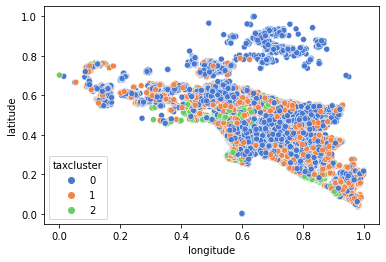

In [15]:
# plotting tax cluster
sns.scatterplot(data=train_scaled, x='longitude', y='latitude', hue='taxcluster', palette = sns.color_palette("muted", n_colors = 3))

## Question: Does the taxcluster I created relate to logerror?


## Hypothesis Testing
H_0: There is no difference of mean between logerror and taxcluster.

H_a: There is a difference of mean between logerror and taxcluster.

In [16]:
alpha = 0.05

F, p = stats.f_oneway(train_scaled[train_scaled.taxcluster == 0].logerror,
                      train[train_scaled.taxcluster == 1].logerror,
                      train[train_scaled.taxcluster == 2].logerror,
                      train[train_scaled.taxcluster == 3].logerror)

if p < alpha:
    print('We reject the null hypothesis\n')
else:
    print('We fail to reject the null hypothesis\n')

print('Anova Test Results on Cluster_Features')
print('F-value:',F)
print('P-value:',p)

We fail to reject the null hypothesis

Anova Test Results on Cluster_Features
F-value: nan
P-value: nan


### Exploration Summary: 

 - All 3 clusters after testing failed to reject null hypothesis and didn't have any significant results.









# Modeling

I'll be utilizing the Regression Models for testing: OLS | LassoLARS | TweedieRegressor | Polynomial Regression


In [17]:
# Create the object
x_train = train_scaled.drop(columns = ['logerror'])
y_train = pd.DataFrame(train_scaled[['logerror']])

x_validate = validate_scaled.drop(columns = ['logerror'])
y_validate = pd.DataFrame(validate_scaled[['logerror']])

x_test = test_scaled.drop(columns = ['logerror'])
y_test = pd.DataFrame(test_scaled[['logerror']])

## Setting Up The Baseline

In [18]:
#looking at the logerror stats to get the mean, median and mode:
print('Log Error Stats\n')
print('average:', round(train.logerror.mean(),6))
print('mode:   ', round(train.logerror.mode()[0],6))
print('median: ', round(train.logerror.median(),6))

Log Error Stats

average: 0.012602
mode:    0.001126
median:  0.006517


In [19]:
#Create mean baseline model
y_train['baseline_mean_pred'] = y_train['logerror'].mean()
y_validate['baseline_mean_pred'] = y_validate['logerror'].mean()

#Create median baseline model
y_train['baseline_median_pred'] = y_train['logerror'].median()
y_validate['baseline_median_pred'] = y_validate['logerror'].median()

#### Let's look at what we need to beat.

In [20]:
#determine RSMSE
results = []

baseline_mean = {
    'model':'baseline_mean',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['baseline_mean_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['baseline_mean_pred'])**(0.5)

}
baseline_median = {
    'model':'baseline_median',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['baseline_median_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['baseline_median_pred'])**(0.5)

}
results.append(baseline_mean)
results.append(baseline_median)

pd.DataFrame(results)

,model,RMSE_train,RMSE_validate
0,baseline_mean,0.084340,0.082428
1,baseline_median,0.084559,0.082596


#### Onwards to modeling train and validate..

## Linnear Regression

In [21]:
# Create the model
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train['logerror'])
y_train['lr_train_pred'] = lr.predict(x_train)
y_validate['lr_validate_pred'] = lr.predict(x_validate)
# Calculate RMSE and compare
lr_rmse = {
    'model':'linear regression',
    'RMSE_train': mean_squared_error(y_train['logerror'], y_train['lr_train_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['logerror'], y_validate['lr_validate_pred'])**(0.5)

}
results.append(lr_rmse)
pd.DataFrame(results)

ValueError: could not convert string to float: 'los_angeles'

# Best Model Visualized

## In conclusion:

- The model does not do better than the baseline.
- Using the unstructured ML method of cluster models does not show to be the best model method when it comes to determining logerror predictions.
- <b> yearbuilt</b> may be an indicator of logerror; however, this requires more investigation.
- Most important takeaway is that more time is needed to explore the data.



### With more time:
- logerror outliers would be beneficial to focus on.
- I would like to try classification models on the data. This may or may not beat the baseline model, but it could still bring in new takeaways.


### Recommendations: 
